In [14]:
import pandas as pd
import osmnx as ox
import geopandas as gpd
import numpy as np
import os
import networkx as nx

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pwd

'/home/cseadmin/dz/TrafficFlowModel/data_process/gis_pipeline'

<AxesSubplot:>

,geometry,fid
0,"LINESTRING (114.04424 22.55066, 114.04424 22.5...",0
1,"LINESTRING (114.04761 22.55094, 114.04768 22.5...",1
2,"LINESTRING (114.04768 22.54928, 114.04667 22.5...",2
3,"LINESTRING (114.04667 22.54928, 114.04665 22.5...",3
4,"LINESTRING (114.04424 22.55066, 114.04665 22.5...",4
...,...,...
241,"LINESTRING (114.06297 22.53551, 114.06304 22.5...",241
242,"LINESTRING (114.06304 22.53372, 114.06305 22.5...",242
243,"LINESTRING (114.06304 22.53372, 114.06133 22.5...",243
244,"LINESTRING (114.06305 22.53176, 114.06133 22.5...",244


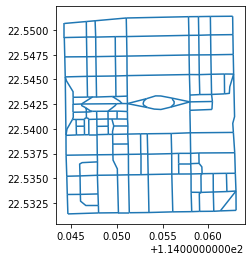

In [25]:
gdf = gpd.read_file("../../data/sz_taxi_202006/gis/shenzhen.shp")
gdf.drop(columns="id", inplace=True)
gdf["fid"]=range(len(gdf))

gdf.plot()
gdf

In [18]:
# https://gis.stackexchange.com/questions/415864/how-do-you-flip-invert-reverse-the-order-of-the-coordinates-of-shapely-geometrie
import shapely

def invert_coords(input_geom):
    if input_geom.type.lower() == "linestring":
        coords = [tuple(coord) for coord in list(input_geom.coords)][::-1]
        out_geom = shapely.geometry.LineString(coords)
    elif input_geom.type.lower() == "multilinestring":
        coords = [list(this_geom.coords)[::-1] for this_geom in input_geom.geoms][::-1]
        out_geom = shapely.geometry.MultiLineString(coords)
    return out_geom

In [21]:
gdf_reverse=gpd.GeoDataFrame(columns=["fid", "geometry"])

for index, row in gdf.iterrows():
    gdf_reverse.loc[len(gdf_reverse)]=[row["fid"]+len(gdf), invert_coords(row["geometry"])]
    
gdf_reverse

,fid,geometry
0,246,"LINESTRING (114.04424 22.54924, 114.04424 22.5..."
1,247,"LINESTRING (114.04768 22.54928, 114.04768 22.5..."
2,248,"LINESTRING (114.04667 22.54928, 114.04667 22.5..."
3,249,"LINESTRING (114.04665 22.55086, 114.04665 22.5..."
4,250,"LINESTRING (114.04665 22.55086, 114.04424 22.5..."
...,...,...
241,487,"LINESTRING (114.06304 22.53372, 114.06297 22.5..."
242,488,"LINESTRING (114.06305 22.53176, 114.06304 22.5..."
243,489,"LINESTRING (114.06133 22.53171, 114.06304 22.5..."
244,490,"LINESTRING (114.06133 22.53171, 114.06305 22.5..."


In [26]:
gdf=gdf.append(gdf_reverse).reset_index(drop=True)

gdf

,geometry,fid
0,"LINESTRING (114.04424 22.55066, 114.04424 22.5...",0
1,"LINESTRING (114.04761 22.55094, 114.04768 22.5...",1
2,"LINESTRING (114.04768 22.54928, 114.04667 22.5...",2
3,"LINESTRING (114.04667 22.54928, 114.04665 22.5...",3
4,"LINESTRING (114.04424 22.55066, 114.04665 22.5...",4
...,...,...
487,"LINESTRING (114.06304 22.53372, 114.06297 22.5...",487
488,"LINESTRING (114.06305 22.53176, 114.06304 22.5...",488
489,"LINESTRING (114.06133 22.53171, 114.06304 22.5...",489
490,"LINESTRING (114.06133 22.53171, 114.06305 22.5...",490


In [29]:
nodes = set()
for index, item in gdf.iterrows():
    nodes.add(item["geometry"].coords[0])
    nodes.add(item["geometry"].coords[-1])
    
d = {}
nodes = list(nodes)
for i in range(len(nodes)):
    d[nodes[i]] = i
    
gdf["u"] = gdf.apply(lambda z: d[z["geometry"].coords[0]], axis=1)
gdf["v"] = gdf.apply(lambda z: d[z["geometry"].coords[-1]], axis=1)

gdf

,geometry,fid,u,v
0,"LINESTRING (114.04424 22.55066, 114.04424 22.5...",0,39,105
1,"LINESTRING (114.04761 22.55094, 114.04768 22.5...",1,129,36
2,"LINESTRING (114.04768 22.54928, 114.04667 22.5...",2,36,68
3,"LINESTRING (114.04667 22.54928, 114.04665 22.5...",3,68,10
4,"LINESTRING (114.04424 22.55066, 114.04665 22.5...",4,39,10
...,...,...,...,...
487,"LINESTRING (114.06304 22.53372, 114.06297 22.5...",487,79,45
488,"LINESTRING (114.06305 22.53176, 114.06304 22.5...",488,73,79
489,"LINESTRING (114.06133 22.53171, 114.06304 22.5...",489,102,79
490,"LINESTRING (114.06133 22.53171, 114.06305 22.5...",490,102,73


In [50]:
u=68
v=10
list(gdf.loc[gdf["u"]==u].loc[gdf["v"]==v]["geometry"].iloc[0].coords)
list(gdf.loc[gdf["u"]==v].loc[gdf["v"]==u]["geometry"].iloc[0].coords)

[(114.0466701269419, 22.54928447584822),
 (114.0466516578344, 22.550857732942088),
 (114.0466516578344, 22.550857732942088),
 (114.0466516578344, 22.550857732942088)]

[(114.0466516578344, 22.550857732942088),
 (114.0466516578344, 22.550857732942088),
 (114.0466516578344, 22.550857732942088),
 (114.0466701269419, 22.54928447584822)]

In [52]:
gdf.to_file("../../data/sz_taxi_202006/fmm_sz_taxi_202006/edges.shp", driver="ESRI Shapefile", encoding="utf8")